# Markovitz Optimization for Insula

## Documentation
https://medium.com/catalyst-crypto/markowitz-portfolio-optimization-for-cryptocurrencies-in-catalyst-b23c38652556


- General Portfolio Optimization Theory: https://www.scielo.br/scielo.php?pid=S0103-65132020000100404&script=sci_arttext


- Amundi : https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwi759LK05vsAhUkxoUKHeUIAQAQFjADegQIBBAC&url=https%3A%2F%2Fresearch-center.amundi.com%2Findex.php%2Fezjscore%2Fcall%2Fezjscamundibuzz%3A%3AsfForwardFront%3A%3AparamsList%3Dservice%3DProxyGedApi%26routeId%3D_dl_YzQ5OWZmZjBmYzY3NTczNGYxNjBhM2Q0OTgwMjYzZWM&usg=AOvVaw03Yd16xS-PSklVmP4r-oNs

- Polytechnique Amundi paper: https://poseidon01.ssrn.com/delivery.php?ID=838069070093066081025099096002017098098027020022033021087020082127086101095031099074123023119103107061027098099089117119093122046042056053036114000089105106071084021044004119097001021126004087080005117118031084016124026086026081019071010092013069007&EXT=pdf


In [32]:
from __future__ import division
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pycoingecko import CoinGeckoAPI
import datetime
import ccxt
from pandas._libs.tslibs.timestamps import Timestamp

from ccxt_market_data import get_market_data, create_ETH_BTC, create_ETH_ETH

In [2]:
data_path = '../data/'

list_currencies_ccxt = [
    'ETH/BTC', 
    'ETH/USDT', 
    'KNC/ETH', 
    'BAT/ETH', 
    'MANA/ETH', 
    'ZRX/ETH',
    'LINK/ETH', 
    'REP/ETH', 
    'RLC/ETH',
    'ELF/ETH', 
    'BNT/ETH', 
    'SNT/ETH', 
    'ENJ/ETH', 
    'LEND/ETH', 
    'LRC/ETH',  
    'POWR/ETH'
]

list_currencies_coingecko = [
    ['POLY_ETH', 'polymath-network'],
    ['REQ_ETH', 'request-network'],
    ['RDN_ETH', 'raiden-network'],
    ['RCN_ETH', 'ripio-credit-network'],
    ['MKR_ETH', 'maker'],
    ['ANT_ETH', 'aragon'],
    ['PNK_ETH', 'kleros'],
    ['GNO_ETH', 'gnosis'],
    ['GEN_ETH', 'daostack'],
    ['MLN_ETH', 'melon'],
    ['UBT_ETH', 'unibright'],
    ['NMR_ETH', 'numeraire'],
    ['LPT_ETH', 'livepeer'],
    ['XBASE_ETH', 'eterbase'],
    ['COT_ETH', 'cotrader'],
    ['AMN_ETH', 'amon'],
    ['MET_ETH', 'metal'],
    ['BLT_ETH', 'bloom'],
    ['SNX_ETH', 'havven'],
    ['TKN_ETH', 'tokencard'],
    ['LOC_ETH', 'lockchain'],
    ['REN_ETH', 'republic-protocol'],
    ['BTU_ETH', 'btu-protocol']
]

In [47]:
def get_market_data_coingecko(symbol, _id, nb_days):
    cg = CoinGeckoAPI()
    try:
        data = cg.get_coin_market_chart_by_id(_id, 'eth', 500)
    except: return '[ERROR] No such coin ID found ({symbol}, {_id})'.format(symbol, _id)

    dates = [datetime.datetime.fromtimestamp(data['prices'][i][0] / 1000).strftime('%Y-%m-%d') for i in range(len(data['prices']))]
    ts = [data['prices'][i][0] for i in range(len(data['prices']))]
    price  = [data['prices'][i][1] for i in range(len(data['prices']))]
    market_caps = [data['market_caps'][i][1] for i in range(len(data['market_caps']))]
    total_volumes = [data['total_volumes'][i][1] for i in range(len(data['total_volumes']))]
    symbols = [symbol]*len(data['total_volumes'])
    source = ['coingecko']*len(data['total_volumes'])
    
    df_data = {'timestamp' : ts, 'date' : dates,'source':source, 'symbol': symbols, 'open': price, 'total_volume': total_volumes} 
    df = pd.DataFrame(df_data)
    df['date'] = df.apply(lambda x: Timestamp(x.date), axis=1)
    
    if df.iloc[-1,:]['date'] == df.iloc[-2,:]['date']:
        return df[-nb_days-1:-1]

    return df[-nb_days:]

for currency in list_currencies_coingecko[4:5]:
    print(get_market_data_coingecko(currency[0], currency[1], 7))

         timestamp       date     source   symbol      open   total_volume
493  1602806400000 2020-10-16  coingecko  MKR_ETH  1.483199   74147.289344
494  1602892800000 2020-10-17  coingecko  MKR_ETH  1.483421  109247.564687
495  1602979200000 2020-10-18  coingecko  MKR_ETH  1.505578   54108.319641
496  1603065600000 2020-10-19  coingecko  MKR_ETH  1.519502   54512.477714
497  1603152000000 2020-10-20  coingecko  MKR_ETH  1.507262   58832.825593
498  1603238400000 2020-10-21  coingecko  MKR_ETH  1.500069   73124.304846
499  1603324800000 2020-10-22  coingecko  MKR_ETH  1.453541   90265.931236


In [58]:
from datetime import date
today = date.today()
str(today)

'2020-10-22'

In [53]:
def get_market_data_ccxt(symbol: str, exchange_: str, timeframe: str, save=False, data_path=None, nb_days: int = 7):
    '''
    symbol: The Symbol of the Instrument/Currency Pair To Download. You can see the list with exchange.markets.keys()
    exchange: The exchange to download from. ex: binance, kraken, bitfinex ...
    timeframe: choices=['1m', '5m','15m', '30m','1h', '2h', '3h', '4h', '6h', '12h', '1d', '1M', '1y']
    save: if you want to save the dataframe in a csv
    data_path: the path to the data
    '''
    # Get our Exchange
    try:
        exchange = getattr (ccxt, exchange_) ()
    except AttributeError:
        print('-'*36,' ERROR ','-'*35)
        print('Exchange "{}" not found. Please check the exchange is supported.'.format(exchange_))
        print('-'*80)
        quit()

    # Check if fetching of OHLC Data is supported
    if exchange.has["fetchOHLCV"] != True:
        print('-'*36,' ERROR ','-'*35)
        print('{} does not support fetching OHLC data. Please use another exchange'.format(exchange_))
        print('-'*80)
        quit()

    # Check requested timeframe is available. If not return a helpful error.
    if (not hasattr(exchange, 'timeframes')) or (timeframe not in exchange.timeframes):
        print('-'*36,' ERROR ','-'*35)
        print('The requested timeframe ({}) is not available from {}\n'.format(timeframe,exchange_))
        print('Available timeframes are:')
        for key in exchange.timeframes.keys():
            print('  - ' + key)
        print('-'*80)
        quit()

    # Check if the symbol is available on the Exchange
    exchange.load_markets()
    if symbol not in exchange.symbols:
        print('-'*36,' ERROR ','-'*35)
        print('The requested symbol ({}) is not available from {}\n'.format(symbol,exchange_))
        print('Available symbols are:')
        for key in exchange.symbols:
            print('  - ' + key)
        print('-'*80)
        quit()

    # eliminate ETH/ETH
    # Get data
    data = exchange.fetch_ohlcv(symbol, timeframe)
    header = ['timestamp', 'open', 'high', 'low', 'close', 'total_volume']
    df = pd.DataFrame(data, columns=header)#.set_index('timestamp')
    df['date'] = pd.to_datetime(df.timestamp, unit='ms')
    df['symbol'] = symbol
    df['source'] = 'ccxt_' + exchange_
    
    if symbol == 'ETH/BTC':
        df[['open','high','low','close']] = 1. / df[['open','high','low','close']]
        df['symbol'] = 'BTC/ETH' 
    
    cols = ['timestamp', 'date', 'source', 'symbol', 'open', 'total_volume']
    df = df[cols]
        
    return df[-nb_days:]

get_market_data_ccxt(symbol='KNC/ETH', 
                    exchange_='binance', 
                    timeframe='1d', 
                    save=True, 
                    data_path=data_path,
                    nb_days= 7)


,timestamp,date,source,symbol,open,total_volume
493,1602806400000,2020-10-16,ccxt_binance,KNC/ETH,0.002471,63776.0
494,1602892800000,2020-10-17,ccxt_binance,KNC/ETH,0.002462,74910.0
495,1602979200000,2020-10-18,ccxt_binance,KNC/ETH,0.002499,40378.0
496,1603065600000,2020-10-19,ccxt_binance,KNC/ETH,0.002469,46149.0
497,1603152000000,2020-10-20,ccxt_binance,KNC/ETH,0.002399,67939.0
498,1603238400000,2020-10-21,ccxt_binance,KNC/ETH,0.002352,186347.0
499,1603324800000,2020-10-22,ccxt_binance,KNC/ETH,0.002389,30754.0


In [40]:
# Here we create the csv with 500 data points per crypto and save it as a csv

for i,pair in enumerate(list_currencies_ccxt):
    if i ==0: pairs_df = get_market_data_ccxt(symbol=pair, 
                    exchange_='binance', 
                    timeframe='1d', 
                    save=True, 
                    data_path=data_path)
    else: 
        to_append_df = get_market_data_ccxt(symbol=pair, 
                    exchange_='binance', 
                    timeframe='1d', 
                    save=True, 
                    data_path=data_path)
        pairs_df = pd.concat([pairs_df, to_append_df], axis=0, ignore_index=True)

for currency in list_currencies_coingecko:
    pairs_df = pd.concat([pairs_df, get_market_data_coingecko(currency[0], currency[1])], axis=0, ignore_index=True)

pairs_df

,timestamp,date,source,symbol,open,total_volume
0,1560211200000,2019-06-11,ccxt_binance,BTC/ETH,32.359318,128279.087000
1,1560297600000,2019-06-12,ccxt_binance,BTC/ETH,32.270556,179283.458000
2,1560384000000,2019-06-13,ccxt_binance,BTC/ETH,31.122592,201941.664000
3,1560470400000,2019-06-14,ccxt_binance,BTC/ETH,32.253903,207795.800000
4,1560556800000,2019-06-15,ccxt_binance,BTC/ETH,32.954358,172508.474000
...,...,...,...,...,...,...
19459,1602979200000,2020-10-18,coingecko,BTU_ETH,0.001207,1551.701355
19460,1603065600000,2020-10-19,coingecko,BTU_ETH,0.001154,570.834695
19461,1603152000000,2020-10-20,coingecko,BTU_ETH,0.001120,1496.153210
19462,1603238400000,2020-10-21,coingecko,BTU_ETH,0.001092,7.702397


In [41]:
pairs_df.to_csv('./crypto_pairs.csv')

In [27]:
for symbol in list_currencies_binance:
    get_market_data(symbol=symbol, 
                    exchange_='binance', 
                    timeframe='1d', 
                    save=True, 
                    data_path=data_path)
    
create_ETH_BTC(data_path)
create_ETH_ETH(data_path)

NameError: name 'list_currencies_binance' is not defined

In [5]:
def create_portfolio(list_pairs: list, exchange: str, timeframe: str):
    '''
    This function is aimed to gather all pairs in a single dataframe. this is our portfolio
    '''
    for i, pair in enumerate(list_pairs_optim):
        filename = '{}-{}-{}.csv'.format(exchange_, pair,timeframe)
        pair_data = pd.read_csv(data_path + filename)
        pair_data = pair_data.set_index('Timestamp')
        pair_data = pd.DataFrame(pair_data['Open']) 
        pair_data.columns = [pair]

        if i==0: df = pair_data
        else: df = pd.concat([df, pair_data], axis=1)

    return df
    
df = create_portfolio(list_pairs=list_pairs_optim,
                exchange=exchange_,
                timeframe=timeframe)

df

,ETH_ETH,BTC_ETH,ZRX_ETH,REP_ETH,ENJ_ETH,BAT_ETH,BLZ_ETH,BNT_ETH,POWR_ETH,SNT_ETH,CVC_ETH,ENG_ETH,ELF_ETH,MANA_ETH,LINK_ETH,KNC_ETH
2019-05-24,1.0,32.089337,0.001282,0.07993,0.000683,0.001424,0.000271,0.002865,0.000494,0.000107,0.000343,0.002012,0.000916,0.000256,0.005497,0.001163
2019-05-25,1.0,32.013318,0.001263,0.07764,0.000647,0.001412,0.000260,0.002867,0.000500,0.000106,0.000326,0.002004,0.001021,0.000239,0.005348,0.001143
2019-05-26,1.0,32.067727,0.001287,0.07775,0.000667,0.001383,0.000255,0.002879,0.000510,0.000105,0.000346,0.001909,0.001001,0.000239,0.004460,0.001132
2019-05-27,1.0,32.586027,0.001224,0.07459,0.000600,0.001321,0.000246,0.002817,0.000468,0.000105,0.000323,0.001756,0.000896,0.000223,0.004091,0.001048
2019-05-28,1.0,32.333161,0.001242,0.07423,0.000602,0.001395,0.000240,0.002800,0.000473,0.000113,0.000325,0.001776,0.000913,0.000223,0.004491,0.001064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002006,NaN,NaN,NaN,NaN
2019-05-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001818,NaN,NaN,NaN,NaN
2019-05-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001771,NaN,NaN,NaN,NaN
2019-05-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001820,NaN,NaN,NaN,NaN


,ETH_ETH,BTC_ETH,ZRX_ETH,REP_ETH,ENJ_ETH,BAT_ETH,BLZ_ETH,BNT_ETH,POWR_ETH,SNT_ETH,CVC_ETH,ENG_ETH,ELF_ETH,MANA_ETH,LINK_ETH,KNC_ETH
2019-05-24,1.0,32.089337,0.001282,0.07993,0.000683,0.001424,0.000271,0.002865,0.000494,0.000107,0.000343,0.002012,0.000916,0.000256,0.005497,0.001163
2019-05-25,1.0,32.013318,0.001263,0.07764,0.000647,0.001412,0.000260,0.002867,0.000500,0.000106,0.000326,0.002004,0.001021,0.000239,0.005348,0.001143
2019-05-26,1.0,32.067727,0.001287,0.07775,0.000667,0.001383,0.000255,0.002879,0.000510,0.000105,0.000346,0.001909,0.001001,0.000239,0.004460,0.001132
2019-05-27,1.0,32.586027,0.001224,0.07459,0.000600,0.001321,0.000246,0.002817,0.000468,0.000105,0.000323,0.001756,0.000896,0.000223,0.004091,0.001048
2019-05-28,1.0,32.333161,0.001242,0.07423,0.000602,0.001395,0.000240,0.002800,0.000473,0.000113,0.000325,0.001776,0.000913,0.000223,0.004491,0.001064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-19,1.0,30.472011,0.001086,0.04011,0.000432,0.000637,0.000299,0.002945,0.000230,0.000065,0.000073,0.002006,0.000269,0.000217,0.026816,0.002625
2019-05-20,1.0,30.472011,0.001086,0.04011,0.000432,0.000637,0.000299,0.002945,0.000230,0.000065,0.000073,0.001818,0.000269,0.000217,0.026816,0.002625
2019-05-21,1.0,30.472011,0.001086,0.04011,0.000432,0.000637,0.000299,0.002945,0.000230,0.000065,0.000073,0.001771,0.000269,0.000217,0.026816,0.002625
2019-05-22,1.0,30.472011,0.001086,0.04011,0.000432,0.000637,0.000299,0.002945,0.000230,0.000065,0.000073,0.001820,0.000269,0.000217,0.026816,0.002625


<ipython-input-6-e01ba03c2cef>:35: RuntimeWarning: invalid value encountered in true_divide
  corr_m = cov_m / np.dot(np.transpose(stds), stds)


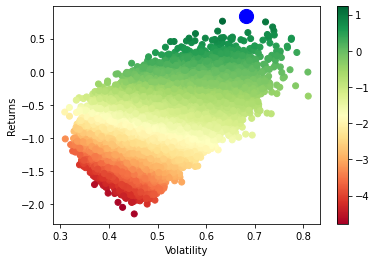

,58058
r,0.836543
stdev,0.681205
sharpe,1.228035
ETH_ETH,0.143085
BTC_ETH,0.149968
ZRX_ETH,0.002224
REP_ETH,0.022153
ENJ_ETH,0.006486
BAT_ETH,0.050855
BLZ_ETH,0.010951


In [6]:
# Test Markowitz Optimization

# Set the time window that will be used to compute expected return and asset correlations
window = 28
# Set the number of days between each portfolio rebalancing
rebalance_period = 14
i = 0
nassets = len(list_pairs_optim)
df_balance = df


# Only rebalance at the beginning of the algorithm execution and
# every multiple of the rebalance period
if i == 0 or i % rebalance_period == 0:
    n = window
    prices = df_balance.fillna(method='ffill')
    display(prices)
    pr = np.asmatrix(prices.values)
    t_prices = prices.iloc[1:n + 1]
    t_val = t_prices.values
    tminus_prices = prices.iloc[0:n]
    tminus_val = tminus_prices.values
    # Compute daily returns (r)
    r = np.asmatrix(t_val / tminus_val - 1)
    # Compute the expected returns of each asset with the average
    # daily return for the selected time window
    m = np.asmatrix(np.mean(r, axis=0))
    # ###
    stds = np.std(r, axis=0)
    # Compute excess returns matrix (xr)
    xr = r - m
    # Matrix algebra to get variance-covariance matrix
    cov_m = np.dot(np.transpose(xr), xr) / n
    # Compute asset correlation matrix (informative only)
    corr_m = cov_m / np.dot(np.transpose(stds), stds)

    # Define portfolio optimization parameters
    n_portfolios = 100000
    results_array = np.zeros((3 + nassets, n_portfolios))
    for p in range(n_portfolios):
        weights = np.random.random(nassets)
        weights /= np.sum(weights)
        w = np.asmatrix(weights)
        p_r = np.sum(np.dot(w, np.transpose(m))) * 365
        p_std = np.sqrt(np.dot(np.dot(w, cov_m),
                               np.transpose(w))) * np.sqrt(365)

        # store results in results array
        results_array[0, p] = p_r
        results_array[1, p] = p_std
        # store Sharpe Ratio (return / volatility) - risk free rate element
        # excluded for simplicity
        results_array[2, p] = results_array[0, p] / results_array[1, p]

        for i, w in enumerate(weights):
            results_array[3 + i, p] = w

    columns = ['r', 'stdev', 'sharpe'] + list_pairs_optim

    # convert results array to Pandas DataFrame
    results_frame = pd.DataFrame(np.transpose(results_array),
                                 columns=columns)
    # locate position of portfolio with highest Sharpe Ratio
    max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
    # locate positon of portfolio with minimum standard deviation
    # min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]


    # create scatter plot coloured by Sharpe Ratio
    plt.scatter(results_frame.stdev,
                results_frame.r,
                c=results_frame.sharpe,
                cmap='RdYlGn')
    plt.xlabel('Volatility')
    plt.ylabel('Returns')
    plt.colorbar()

    # plot blue circle to highlight position of portfolio
    # with highest Sharpe Ratio
    plt.scatter(max_sharpe_port[1],
                max_sharpe_port[0],
                marker='o',
                color='b',
                s=200)

    plt.show()
    display(pd.DataFrame(max_sharpe_port))

i += 1



In [7]:
trading_pair_out = 'ETH_ETH'
exchange_ = 'binance'
timeframe = '1d'
filename = '{}-{}-{}.csv'.format(exchange_, trading_pair_out,timeframe)
pd.read_csv(data_path + filename)

,Timestamp,Open,High,Low,Close,Volume
0,2019-05-24,1.0,1.0,1.0,1.0,447066.92596
1,2019-05-25,1.0,1.0,1.0,1.0,332544.38731
2,2019-05-26,1.0,1.0,1.0,1.0,450090.22324
3,2019-05-27,1.0,1.0,1.0,1.0,635463.50204
4,2019-05-28,1.0,1.0,1.0,1.0,409443.69364
...,...,...,...,...,...,...
495,2020-09-30,1.0,1.0,1.0,1.0,498943.23226
496,2020-10-01,1.0,1.0,1.0,1.0,758349.31959
497,2020-10-02,1.0,1.0,1.0,1.0,733571.84211
498,2020-10-03,1.0,1.0,1.0,1.0,303595.71901


In [8]:
report = pd.DataFrame(max_sharpe_port)[3:]
report = round(100*report,2)
report

,58058
ETH_ETH,14.31
BTC_ETH,15.00
ZRX_ETH,0.22
REP_ETH,2.22
ENJ_ETH,0.65
BAT_ETH,5.09
BLZ_ETH,1.10
BNT_ETH,4.70
POWR_ETH,6.02
SNT_ETH,6.26
